In [56]:
import random

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline

In [45]:
data_dir = join('.','..', 'FastData')
files = !ls $data_dir
files = [f for f in files if f.endswith('.csv')]
ids = list(set([x[:3] for x in files]))
# files = random.sample(files, 4)

In [46]:
ids = list(set([x[:3] for x in files]))

In [47]:
# Looking for data in a shape of 'Part_id', 'Block_no', 'Corr','Stimulus Time'

In [48]:
aggregated = list()
for idx, id in enumerate(ids):
    fs = [x for x in files if x.startswith(id)]
    data = pd.concat([pd.read_csv(join(data_dir, fs[0])),pd.read_csv(join(data_dir, fs[1]))])

    # Add block number 

    block_no = list()
    curr_block_no = 0
    for row in data.iterrows():
        row_no, row_data = row
        prev_row = data.iloc[row_no - 1]

        if row_no in [0, 1]:
            row_block_no = 0
        elif (row_data.Trial_type == 'training' and prev_row.Trial_type in ['experiment', 'no_adaptation']):
            curr_block_no += 1
        row_block_no = curr_block_no 

        block_no.append(row_block_no)
    data['Block_no'] = block_no

    ####
    experiment = data.query("Trial_type == 'experiment'")

    res = experiment.groupby('Block_no').mean()[['Stimulus Time', 'Corr']]
    res.reset_index(inplace=True)
    res['Part_id'] = fs[0].split('_')[0]
    res = res.reindex(columns=['Part_id', 'Block_no', 'Corr','Stimulus Time'])
    aggregated.append(res)


# pd.concat(aggregated).to_csv('High_res_saccades.csv', index=False)

# Slow wave visualisation 

## Gaussian Blur 

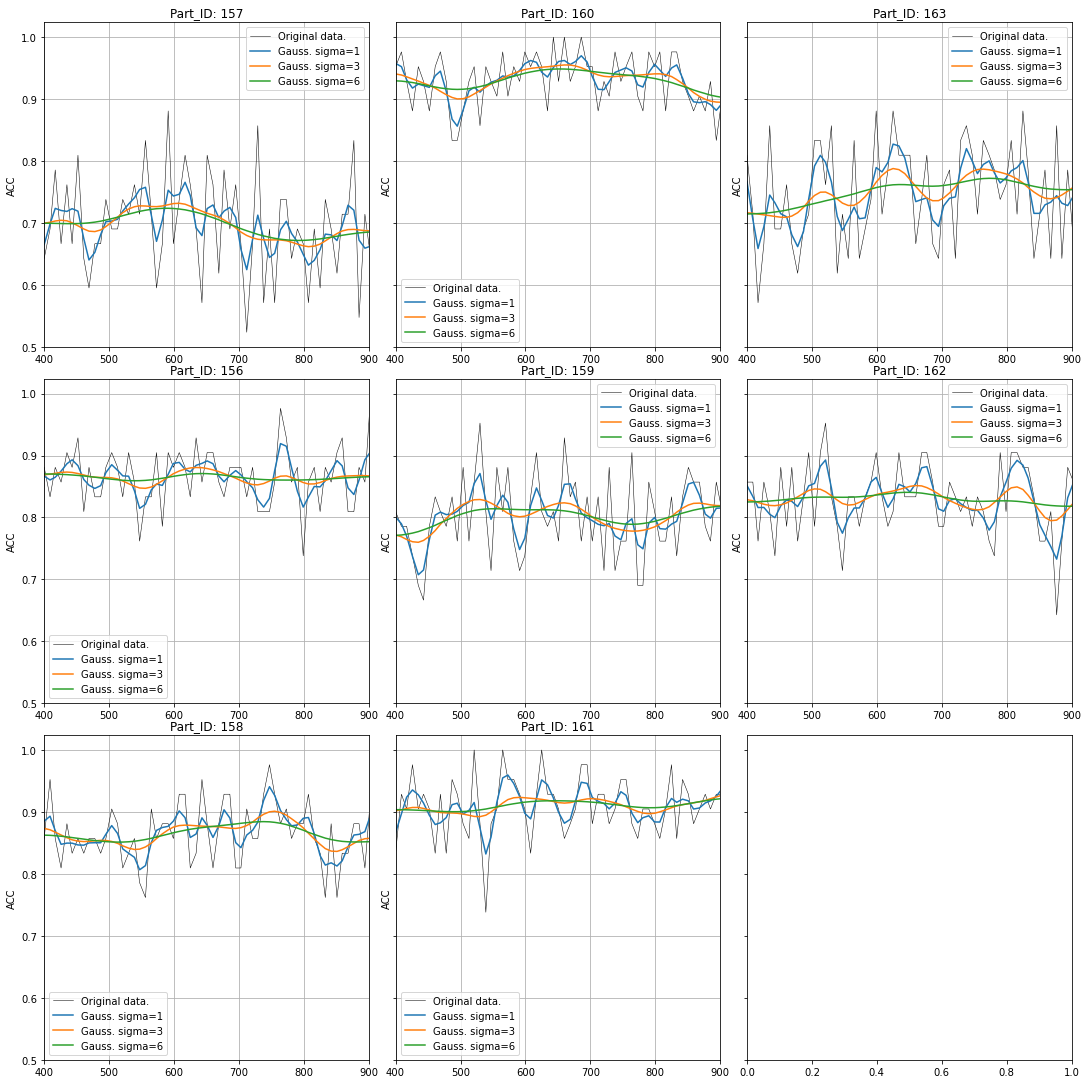

In [61]:
fig, axs = plt.subplots(1+len(ids)//3, 3, figsize=(15, 15), sharey=True)
axs = axs.flatten()
fig.tight_layout()
for idx, id in enumerate(ids):
    fs = [x for x in files if x.startswith(id)]
    data = pd.concat([pd.read_csv(join(data_dir, fs[0])),pd.read_csv(join(data_dir, fs[1]))])

    experiment = data.query("Trial_type == 'experiment'")
    acc = experiment.groupby("CSI").mean().Corr.to_numpy()

    t = np.round((np.arange(61) * 8.666666666) + 400)
    axs[idx].plot(t, acc, label=f'Original data.', color='black', linewidth=0.5)
    for sig in [1, 3, 6]:
        axs[idx].plot(t, gaussian_filter1d(acc, sig), label=f'Gauss. sigma={sig}')
    axs[idx].set_title(f"Part_ID: {id}" )
    axs[idx].set_ylabel("ACC")
    axs[idx].set_xlim([400,900])

    axs[idx].legend()
    axs[idx].grid()

fig.show()

Nie chce psuć niespodzianki, ale może się okazać, że to jeden z lepszych wyników. 

## Moving avg

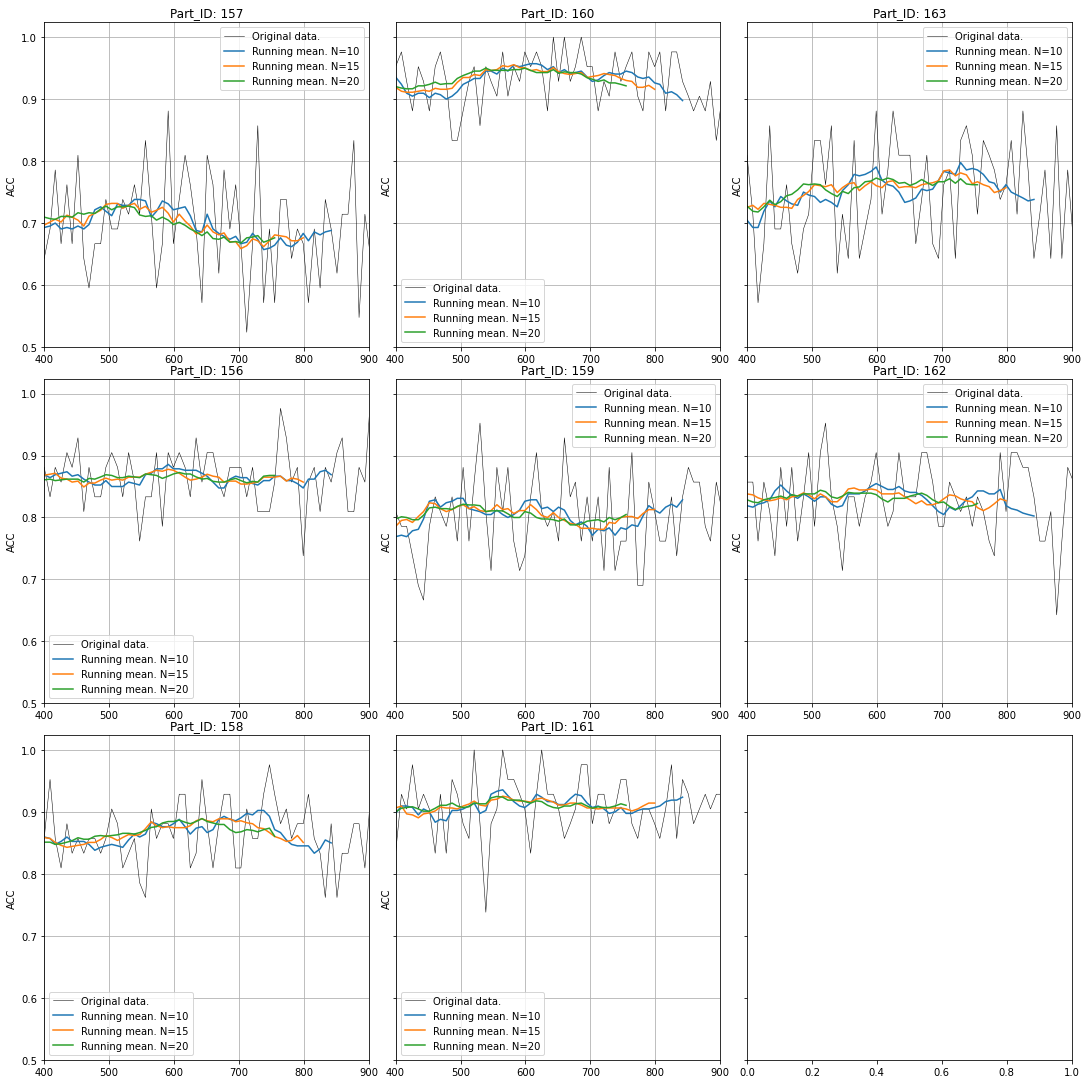

In [49]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

fig, axs = plt.subplots(1+len(ids)//3, 3, figsize=(15, 15), sharey=True)
axs = axs.flatten()
fig.tight_layout()
for idx, id in enumerate(ids):
    fs = [x for x in files if x.startswith(id)]
    data = pd.concat([pd.read_csv(join(data_dir, fs[0])),pd.read_csv(join(data_dir, fs[1]))])

    experiment = data.query("Trial_type == 'experiment'")
    acc = experiment.groupby("CSI").mean().Corr.to_numpy()

    t = np.round((np.arange(61) * 8.666666666) + 400)
    axs[idx].plot(t, acc, label=f'Original data.', color='black', linewidth=0.5)
    for N in [10, 15, 20]:
        axs[idx].plot(t[:62-N], running_mean(acc, N), label=f'Running mean. N={N}')
    axs[idx].set_title(f"Part_ID: {id}" )
    axs[idx].set_ylabel("ACC")
    axs[idx].set_xlim([400,900])

    axs[idx].legend()
    axs[idx].grid()

fig.show()

Średnie kroczące całkiem ładnie pokazują wolną fazę. Problem w tym, że tracimy dość dużo punktów, lowess wydaje się teraz tym lepszym pomysłem.

# Loess Regression

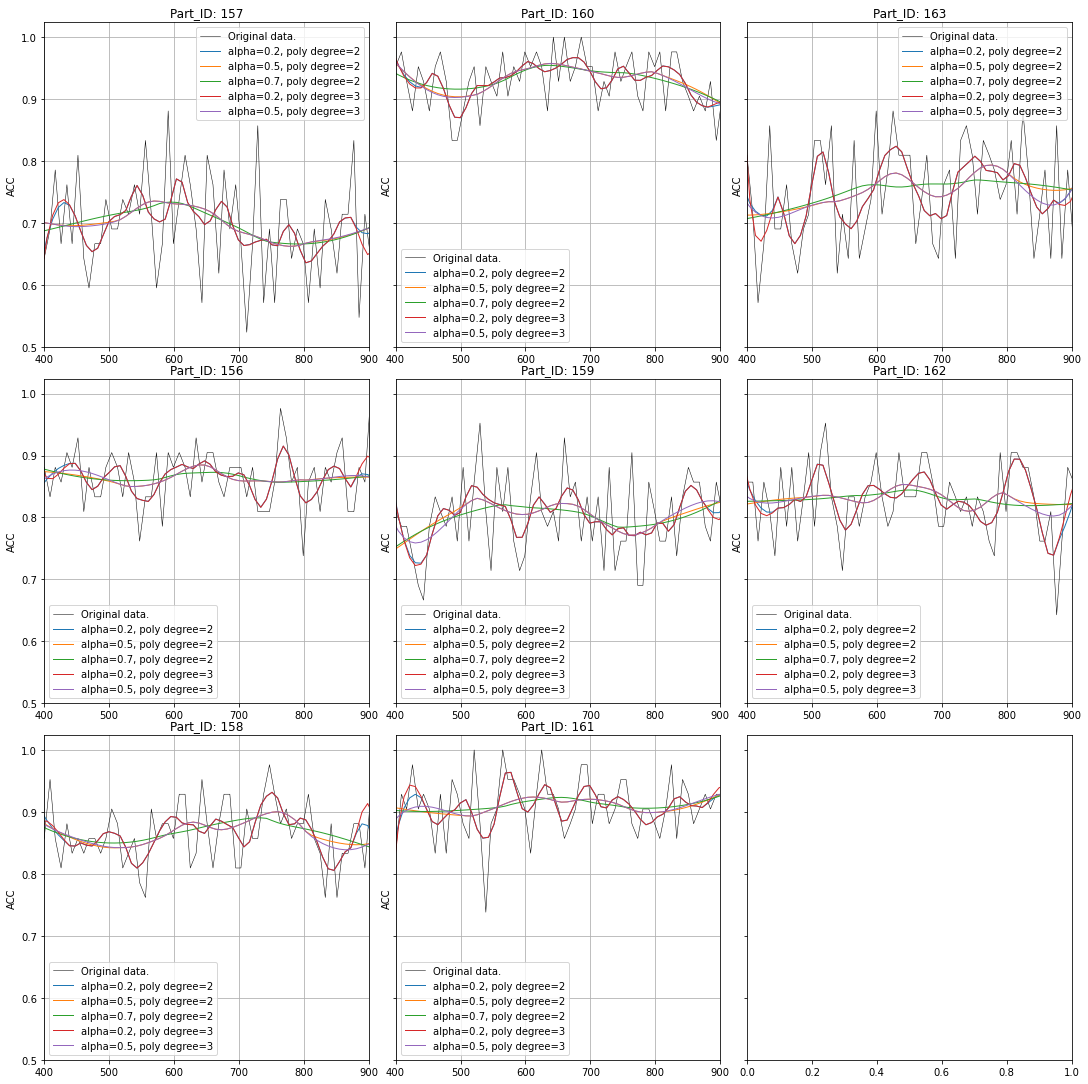

In [53]:
def loc_eval(x, b):
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)


def loess(xvals, yvals, data, alpha, poly_degree=1):
    all_data = sorted(zip(data[xvals].tolist(), data[yvals].tolist()), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)
    evalDF = pd.DataFrame(columns=['v','g'])
    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = min(xvals)-(.5*avg_interval)
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T
    for i in v:
        iterpos = i[0]
        iterval = i[1]
        iterdists = sorted([(j, np.abs(j-iterval)) for j in xvals], key=lambda x: x[1])
        _, raw_dists = zip(*iterdists)
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 if j[1]<=1 else 0)) for j in scaled_dists]
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))
        W         = np.diag(weights)
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ yvals)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })
        evalDF = pd.concat([evalDF, iterDF2])
    evalDF = evalDF[['v','g']]
    return(evalDF)


fig, axs = plt.subplots(1+len(ids)//3, 3, figsize=(15, 15), sharey=True)
axs = axs.flatten()
fig.tight_layout()
for idx, id in enumerate(ids):
    fs = [x for x in files if x.startswith(id)]
    data = pd.concat([pd.read_csv(join(data_dir, fs[0])),pd.read_csv(join(data_dir, fs[1]))])

    experiment = data.query("Trial_type == 'experiment'")
    acc = experiment.groupby("CSI").mean().Corr.to_numpy()

    t = np.round((np.arange(61) * 8.666666666) + 400)

    df = pd.DataFrame({"Xvalue" : t, "Yvalue" : acc})

    axs[idx].plot(t, acc, label=f'Original data.', color='black', linewidth=0.5)
    for (a, poly_d) in [(0.2, 2),(0.5, 2), (0.7, 2), (0.2, 3), (0.5, 3)]:
        evalDF = loess("Xvalue", "Yvalue", data = df, alpha=a, poly_degree=poly_d)
        axs[idx].plot(evalDF['v'], evalDF['g'], linewidth= 1, label=f"alpha={a}, poly degree={poly_d}")

    axs[idx].set_title(f"Part_ID: {id}" )
    axs[idx].set_ylabel("ACC")
    axs[idx].set_xlim([400,900])

    axs[idx].legend()
    axs[idx].grid()

fig.show()


Myślę, że to fajny trop. Kwestia jedynie dobrania parametrów. Szczególnie alpha = 0.7 poly_degree = 0.7 wydaje się sensowne. (Mniej sensowne wydaje się mówienie o stopniu wielomianu w ramach takiego rodzaju regresji, nie mniej jednak intuicyjnie to działa.) 

# Obwiednie

Poniżej przykładowa obwiednia z jednej osoby.

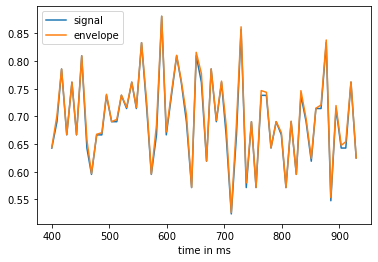

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

signal = np.array([0.64285714, 0.69047619, 0.78571429, 0.66666667, 0.76190476,
                   0.66666667, 0.80952381, 0.64285714, 0.5952381 , 0.66666667,
                   0.66666667, 0.73809524, 0.69047619, 0.69047619, 0.73809524,
                   0.71428571, 0.76190476, 0.71428571, 0.83333333, 0.71428571,
                   0.5952381 , 0.66666667, 0.88095238, 0.66666667, 0.73809524,
                   0.80952381, 0.76190476, 0.69047619, 0.57142857, 0.80952381,
                   0.76190476, 0.61904762, 0.78571429, 0.69047619, 0.76190476,
                   0.66666667, 0.52380952, 0.66666667, 0.85714286, 0.57142857,
                   0.69047619, 0.57142857, 0.73809524, 0.73809524, 0.64285714,
                   0.69047619, 0.66666667, 0.57142857, 0.69047619, 0.5952381 ,
                   0.73809524, 0.69047619, 0.61904762, 0.71428571, 0.71428571,
                   0.83333333, 0.54761905, 0.71428571, 0.64285714, 0.64285714,
                   0.76190476, 0.625     ])

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)

t = np.round((np.arange(62) * 8.666666666) + 400)

fig = plt.figure()
ax0 = fig.add_subplot(111)
ax0.plot(t, signal, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in ms")
ax0.legend()
fig.show()

Jak widać z obwiedniami jest problem i nie wiem czy to kwestia małej próby, czy wybitnej niegładkości, czy może "brzydkiemu widmu". Zadałem pytanie na stackoverflow, jak narazie nikt się nie wypowiedział.  